In [1]:
from cvrpy.pso import PSO

pso = PSO(
    lambda vec: 1/sum(vec),
    num_iterations=100,
    num_particles=100,
    num_dimensions=20
)

solution = pso.optimize()

print(type(solution))
print(solution.position)


<class 'cvrpy.pso.Particle'>
[1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]


In [1]:
from loggibud.v1.types import CVRPInstance
from cvrpy.particle.decoder import ParticleDecoder
from cvrpy.particle.factory import ParticleFactory

instance = CVRPInstance.from_file('data/cvrp_castanhal.json')
print(f'Número de clientes: {len(instance.deliveries)}')
print(f'Capacidade máxima por veículo: {instance.vehicle_capacity}')

# Cria uma partícula e decodifica gerando um CVRPSolution
particle = ParticleFactory.create_for(instance, sum, num_vehicles=5)
solution = ParticleDecoder.decode(particle.position, instance)

for vehicle in solution.vehicles:
    sizes = [d.size for d in vehicle.deliveries]
    print(f'Total = {sum(sizes)}', sizes, f'{len(sizes)} clientes')


Número de clientes: 35
Capacidade máxima por veículo: 180
Total = 135 [7, 4, 1, 3, 9, 10, 2, 1, 1, 1, 4, 7, 7, 9, 4, 10, 4, 4, 2, 4, 7, 6, 10, 2, 8, 8] 26 clientes
Total = 0 [] 0 clientes
Total = 40 [3, 10, 9, 5, 6, 7] 6 clientes
Total = 19 [8, 9, 2] 3 clientes
Total = 0 [] 0 clientes


## Função Objetivo

Deve calcular a distância percorrida em cada rota, para isso será usado o OSRM
como backend fornecedor dos cálculos de distâncias percorridas entre um ponto
e outro no mapa.

Dado um objeto de CVRPSolution que possui as entregas distribuídas entre os
veículos, pra cada veículo, a função deve calcular a distância entre o depósito
e a primeira entrega, depois entre a primeira e a segunda entrega e assim por
diante até voltar da última entrega para o depósito.

In [ ]:
# Comando para executar o container do osrm

# !docker run --rm -t -id --name osrm -p 5000:5000 -v "${PWD}/osrm:/data" osrm/osrm-backend:v5.24.0 osrm-routed --algorithm ch /data/brazil-201110.osrm --max-table-size 10000

In [2]:
from cvrpy.particle.decoder import ParticleDecoder
from cvrpy.particle.factory import ParticleFactory
from cvrpy.route_functions import vehicle_distance_traveled

# Cria uma partícula e decodifica gerando um CVRPSolution
particle = ParticleFactory.create_for(instance, sum, num_vehicles=5)
solution = ParticleDecoder.decode(particle.position, instance)

for i, vehicle in enumerate(solution.vehicles):
    print(f'Veículo {i+1}')
    print(f'\tNúmero de entregas: {len(vehicle.deliveries)}')
    print(f'\tDistância total: {vehicle_distance_traveled(vehicle)}')
    print(f'\tPeso: {vehicle.occupation}')

vehicle_distance_traveled(solution.vehicles[0])

Veículo 1
	Número de entregas: 5
	Distância total: 9766.7
	Peso: 31
Veículo 2
	Número de entregas: 24
	Distância total: 38805.4
	Peso: 128
Veículo 3
	Número de entregas: 0
	Distância total: 0.0
	Peso: 0
Veículo 4
	Número de entregas: 3
	Distância total: 66725.7
	Peso: 16
Veículo 5
	Número de entregas: 3
	Distância total: 109009.4
	Peso: 19


9766.7

## Aplicando o Random Walk

Rodando 1a execução... OK
Rodando 2a execução... OK


(<Figure size 1080x504 with 1 Axes>,
 <AxesSubplot:title={'center':'Média e Desvio Padrão do fitness durante as execuções'}, xlabel='Iteração', ylabel='Valor da função objetivo'>)

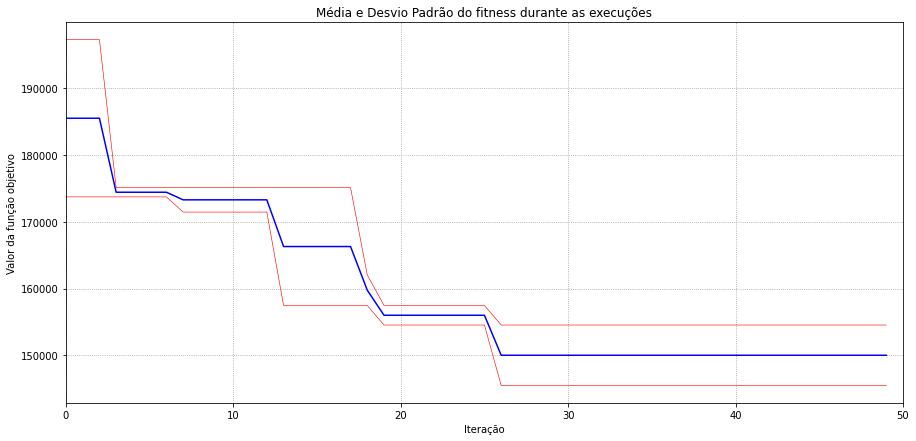

In [7]:
from cvrpy.rw import RandomWalk
from cvrpy.plotting import Plotter
from loggibud.v1.types import CVRPInstance

problem = CVRPInstance.from_file('./data/cvrp_castanhal.json')

rw = RandomWalk(num_individuals=4)

rw_convergences = []
for i in range(2):
    print(f'Rodando {i+1}a execução...', end=' ')
    rw.run(until=50, problem=problem, num_vehicles=5, verbose=False)
    rw_convergences.append(rw.get_convergence().copy())
    print('OK')

Plotter.plot_convergence(rw_convergences)

## Aplicando o PSO

(<Figure size 1080x504 with 1 Axes>,
 <AxesSubplot:title={'center':'Média e Desvio Padrão do fitness durante as execuções'}, xlabel='Iteração', ylabel='Valor da função objetivo'>)

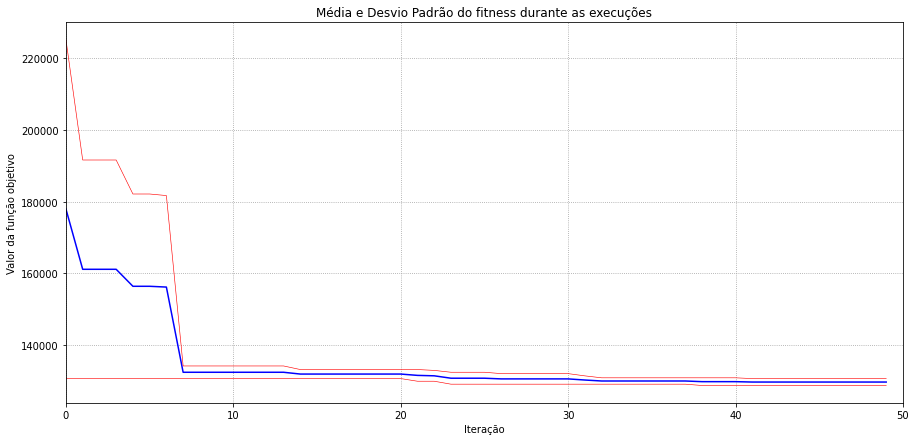

In [6]:
from loggibud.v1.types import CVRPInstance
from cvrpy.pso import PSO
from cvrpy.plotting import Plotter

problem = CVRPInstance.from_file('data/cvrp_castanhal.json')
pso = PSO(problem, num_particles=4, num_vehicles=5)

c = []
for _ in range(2):
    pso.optimize(until=50)
    c.append(pso.convergence.copy())

Plotter.plot_convergence(c)